# Importing Libraries and Helper Functions


In [1]:
!pip3 install tensorflow==2.1.0 pillow matplotlib
!pip3 install git+https://github.com/am1tyadav/tfutils.git

     |████████████████████████████████| 120.8 MB 154 kB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 448 kB 10.3 MB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=7f0d5b75cde889e9da5a20706ad23534c532de5a5b6c9b2640a407c34892beea
  Stored in directory: /Users/priyarajpurohit/Library/Caches/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast


  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.13.2
    Uninstalling tensorflow-1.13.2:
      Successfully uninstalled tensorflow-1.13.2
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
  Cloning https://github.com/am1tyadav/tfutils.git to /private/var/folders/f1/l6_wf5vx0_d5ppn84ynb1f0w0000gn/T/pip-req-build-1dhykp1u
  Created wheel for tfu

In [2]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


# Importing and Plotting the Data

In [3]:
(x_train,y_train),(x_test,y_test) = tfutils.datasets.mnist.load_data(one_hot=False)

x_train=tfutils.datasets.mnist.load_subset([0],x_train,y_train)
x_test=tfutils.datasets.mnist.load_subset([0],x_test,y_test)

x=np.concatenate([x_train,x_test],axis=0)

<IPython.core.display.Javascript object>


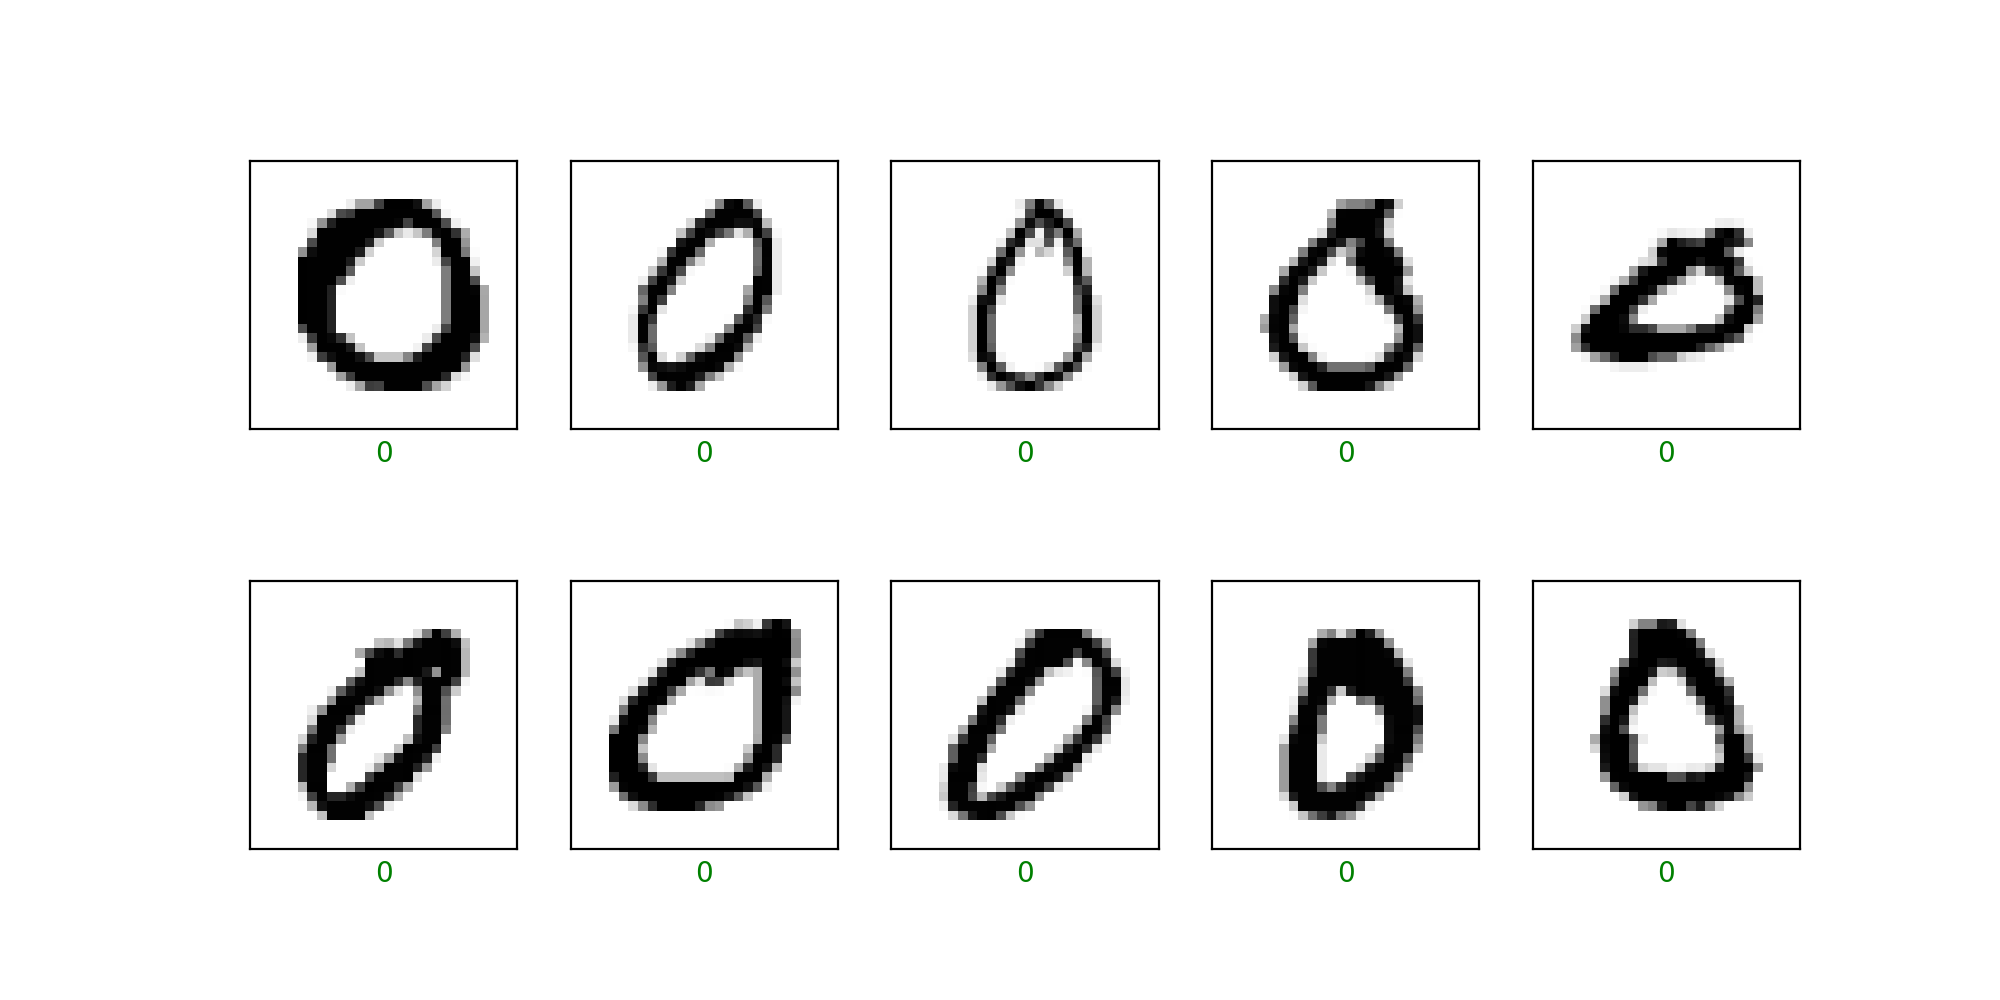

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [4]:
tfutils.datasets.mnist.plot_ten_random_examples(plt,x,np.zeros((x.shape[0],1)))

# Discriminator


In [5]:
discriminator=Sequential([
    
    Conv2D(64,3,strides=2,input_shape=(28,28,1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128,5,strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256,5,strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1,activation='sigmoid')
])

opt=tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)         8

# Generator

In [6]:
generator= Sequential([
    Dense(256,activation='relu',input_shape=(1, )),
    Reshape((1,1,256)),
    
    Conv2DTranspose(256,5,activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128,5,activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64,5,strides=2,activation='relu'),
    BatchNormalization(),
        
    Conv2DTranspose(32,5,activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(1,4,activation='sigmoid')
])
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)       

<IPython.core.display.Javascript object>


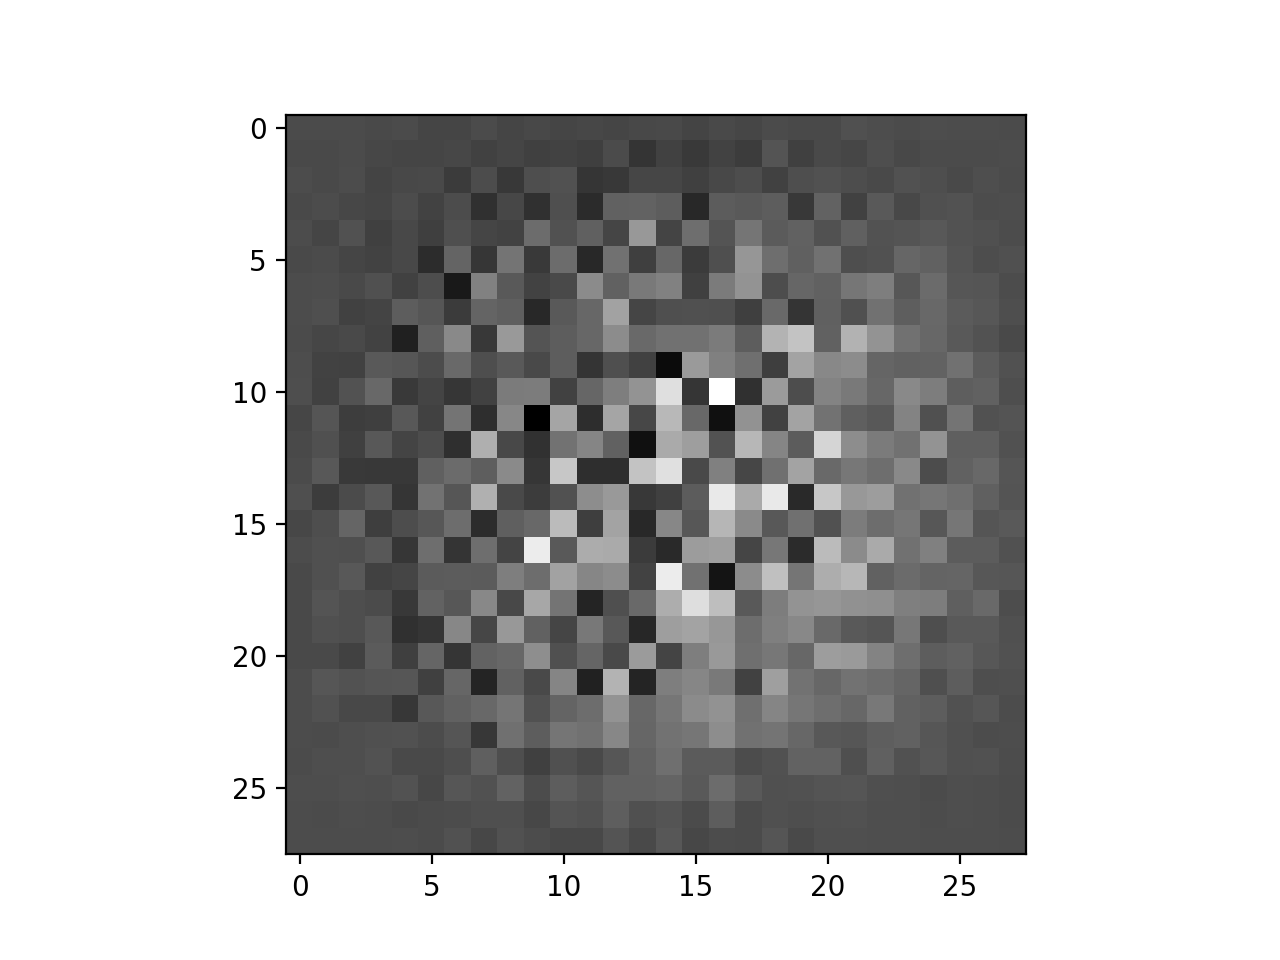

In [7]:
noise=np.random.randn(1,1)
gen_image=generator.predict(noise)[0]
plt.figure()
plt.imshow(np.reshape(gen_image,(28,28)),cmap='binary')
plt.show()

# Generative Adversarial Network (GAN)

In [8]:
input_layer=tf.keras.layers.Input(shape=(1,))
gen_out=generator(input_layer)
disc_out=discriminator(gen_out)

gan=Model(
input_layer,
disc_out)

discriminator.trainable=False
gan.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [9]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Training the GAN

In [10]:
epochs=25
batch_size=128
steps_per_epoch=int(2 * x.shape[0]/batch_size)

print(steps_per_epoch)

107


<IPython.core.display.Javascript object>


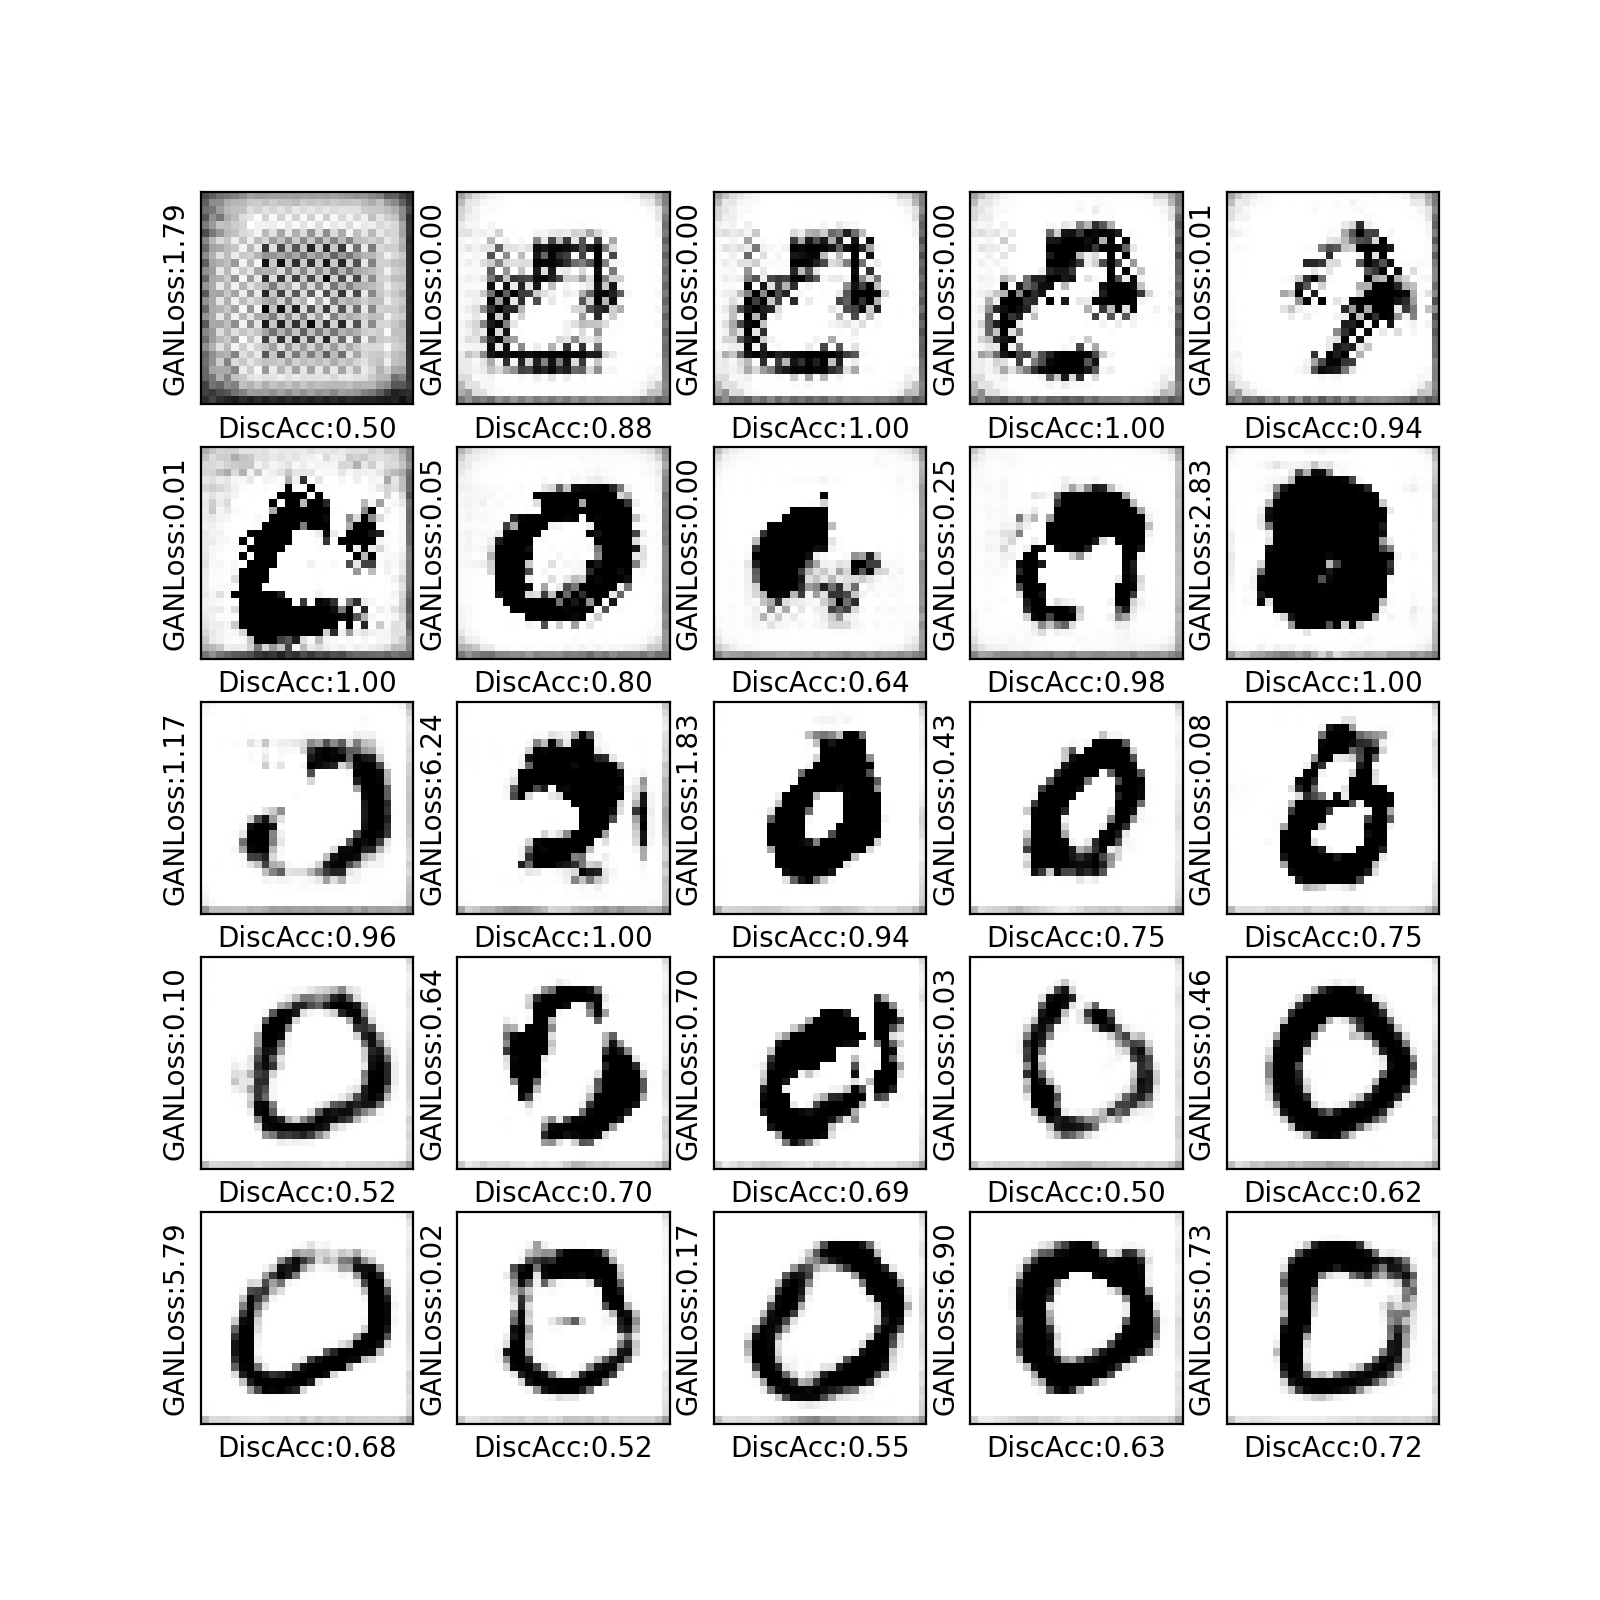

In [11]:
dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))
noise_dim=1
for e in range(0, epochs):
    
    dp.start_of_epoch(e)
    
    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size/2)*step: int(batch_size/2)*(step + 1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))

        noise = np.random.randn(int(batch_size/2), noise_dim)
        generated_examples = generator.predict(noise)

        x_batch = np.concatenate([generated_examples, true_examples], axis=0)
        y_batch = np.array([0] * int(batch_size/2) + [1] * int(batch_size/2))

        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]

        # train the discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False

        # train the generator
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))

        _, acc = discriminator.evaluate(x_batch, y_batch, verbose=False)

    noise = np.random.randn(1, noise_dim)
    generated_example = generator.predict(noise)[0]
    
    dp.end_of_epoch(np.reshape(generated_example, (28, 28)), 'binary',
                   'DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))